In [57]:
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import special
from scipy.optimize import minimize
from scipy.interpolate import interp1d

from mpmath import invertlaplace
# from mpmath import *
# mp.dps = 10; mp.pretty = True

from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
def simulate_HSDM_2D(a, mu, ndt, sigma=1, dt=0.001):
    x = np.zeros(mu.shape)
    
    rt = 0
    
    while np.linalg.norm(x, 2) < a(rt):
        x += mu*dt + sigma*np.sqrt(dt)*np.random.normal(0, 1, mu.shape)
        rt += dt
    
    theta = np.arctan2(x[1], x[0])   
    
    return ndt+rt, theta

In [59]:
def k(a, da, t, q, sigma=2):
    return 0.5 * (q - 0.5*sigma - da(t))

# def psi(a, da, t, z, tau, q, sigma=2):
#     kk = k(a, da, t, q, sigma)
    
#     term1 = 1./(sigma*(t - tau)) * np.exp(- (a(t) + z)/(sigma*(t-tau)))
#     term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
#     term3 = da(t) - (a(t)/(t-tau)) + kk
#     term4 = besseli(q/sigma-1, 2*sqrt(a(t)*z)/(sigma*(t-tau)))
#     term5 = (sqrt(a(t)*z)/(t-tau)) * besseli(q/sigma, 2*sqrt(a(t)*z)/(sigma*(t-tau)))
#     return term1 * term2 * (term3 * term4 + term5)


def psi(a, da, t, z, tau, q, sigma=2):
    kk = k(a, da, t, q, sigma)
    
    term1 = 1./(sigma*(t - tau)) * np.exp(- (a(t) + z)/(sigma*(t-tau)))
    term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
    prod = term1*term2
    term3 = da(t) - (a(t)/(t-tau)) + kk
    term4 = prod*term3*(special.iv(q/sigma-1, 2*np.sqrt(a(t)*z)/(sigma*(t-tau))))
    term5 = prod*(np.sqrt(a(t)*z)/(t-tau)) * special.iv(q/sigma, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
    print(special.iv(q/sigma, 2*np.sqrt(a(t)*z)/(sigma*(t-tau))), 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
#     term4 = (s(q/sigma-1, 2*sqrt(a(t)*z)/(sigma*(t-tau))))
#     term5 = ((sqrt(a(t)*z)/(t-tau)) * besseli(q/sigma, 2*sqrt(a(t)*z)/(sigma*(t-tau))))
#     return term1 * term2 * (term3 * term4 + term5)
    return term4 + term5

def psi_eps(a, da, t, z, tau, q, sigma=2):
    kk = k(a, da, t, q, sigma)
    
    term1 = 1./(sigma*(t - tau)) * np.exp(- (a(t) + z)/(sigma*(t-tau)))
    term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
    prod = term1*term2
    term3 = da(t) - (a(t)/(t-tau)) + kk
    term4 = prod*term3*(special.ive(q/sigma-1, 2*np.sqrt(a(t)*z)/(sigma*(t-tau))))
    term5 = prod*(np.sqrt(a(t)*z)/(t-tau)) * special.ive(q/sigma, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
    print(special.iv(q/sigma, 2*np.sqrt(a(t)*z)/(sigma*(t-tau))), 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
#     term4 = (s(q/sigma-1, 2*sqrt(a(t)*z)/(sigma*(t-tau))))
#     term5 = ((sqrt(a(t)*z)/(t-tau)) * besseli(q/sigma, 2*sqrt(a(t)*z)/(sigma*(t-tau))))
#     return term1 * term2 * (term3 * term4 + term5)
    return term4 + term5

def ie_bessel_fpt(a, da, q, z, dt=0.1, T_max=2):
    g = [0]
    T = [0]
    g.append(-2*psi(a, da, dt, z, 0, q))
    T.append(dt)
    
    for n in range(2, int(T_max/dt)+2):
        s = -2 * psi(a, da, n*dt, z, 0, q)

        for j in range(1, n):
            s += 2 * dt * g[j] * psi(a, da, n*dt, a(j*dt), j*dt, q)

        g.append(s)
        T.append(n*dt)
        
    g = np.asarray(g)
    T = np.asarray(T)
    
    gt = interp1d(T, g)
    return gt

In [60]:
def HSDM_2D_likelihood(prms, RT, Theta):
    ndt = prms[1]
    mu = np.array([prms[2], prms[3]])
    
    if prms[0] <= 2:
        a = lambda t: prms[0]**2
        da = lambda t: 0
        fpt = ie_bessel_fpt(a, da, mu.shape[0], 0.0001, 
                            dt=0.01, T_max=max(RT))
    else:
        a = prms[0]
        nu = (mu.shape[0]-2)/2
        fixed = 2**nu * gamma(1+nu)
        fpt = lambda p: (a*sqrt(2*p))**nu/fixed *  1./besseli(nu, a*sqrt(2*p))
    
    log_lik = 0
    for i in range(len(RT)):
        rt, theta = RT[i], Theta[i]
        if rt - ndt > 0.001:
            mu_dot_x0 = mu[0]*np.cos(theta)
            mu_dot_x1 = mu[1]*np.sin(theta)
            term1 = prms[0] * (mu_dot_x0 + mu_dot_x1)
            term2 = 0.5 * np.linalg.norm(mu, 2)**2 * (rt - ndt)
            
            if prms[0] < 2: 
                density = exp(term1 - term2) * fpt(rt - ndt)

                if 0.1**14 < density:
                    log_lik += -log(density)
                else:
                    log_lik += -log(0.1**14)
            else:
                density = exp(term1 - term2) * invertlaplace(fpt, rt-ndt, method='talbot')
                if 0.1**14 < density:
                    log_lik += -log(density)
                else:
                    log_lik += -log(0.1**14)
        else:
            log_lik += -np.log(0.1**14)
        
    return log_lik

In [61]:
recovery_df = {'threshold_true': [],
               'threshold_estimate': [],
               'ndt_true': [],
               'ndt_estimate': [],
               'mu1_true': [],
               'mu1_estimate': [],
               'mu2_true': [],
               'mu2_estimate': []}

min_threshold = 0.5
max_threshold = 5

min_ndt = 0.1
max_ndt = 1

min_mu = -3.5
max_mu = 3.5

In [62]:
threshold = 5
fpt = ie_bessel_fpt(lambda t: 1, 
                    lambda t: 0, 2/threshold**2, 0.0000000000001, 
                    dt=0.01, T_max=4)

0.6567882881938607 3.162277660168379e-05
0.6388283777990312 1.5811388300841894e-05
1.0737430737292022e+42 100.0
0.6285510404024979 1.0540925533894598e-05
2.9325063836566182e+20 50.00000000000001
1.0737430737292178e+42 100.00000000000001
0.6213595821855864 7.905694150420947e-06
20777661823986.566 33.333333333333336
2.9325063836565956e+20 50.0
1.0737430737291875e+42 99.99999999999999
0.6158381648602077 6.324555320336758e-06
5774371956.45631 25.0
20777661823986.426 33.33333333333333
2.932506383656577e+20 49.99999999999999
1.0737430737291875e+42 99.99999999999999
0.611363279136382 5.270462766947299e-06
43556494.134057105 20.0
5774371956.45633 25.000000000000004
20777661823986.566 33.333333333333336
2.9325063836566182e+20 50.00000000000001
1.073743073729263e+42 100.00000000000006
0.6076051946636397 4.517539514526255e-06
1704383.1317820826 16.666666666666664
43556494.134057105 20.0
5774371956.456293 24.999999999999996
20777661823986.426 33.33333333333333
2.932506383656577e+20 49.999999999999

2.411994898789034 2.0833333333333335
2.489971833564469 2.1276595744680864
2.5747918345273173 2.173913043478261
2.6672997766747613 2.2222222222222237
2.768476046294385 2.272727272727273
2.8794634599497777 2.3255813953488387
3.001600599984496 2.3809523809523814
3.136463361649584 2.439024390243904
3.285917086965923 2.5000000000000004
3.4521824542673145 2.564102564102566
3.6379193891391366 2.6315789473684217
3.8463347929471223 2.7027027027027053
4.0813220435150654 2.7777777777777786
4.347643300655493 2.85714285714286
4.651170091764408 2.9411764705882364
4.999204146201713 3.030303030303034
5.400910068026545 3.1250000000000018
5.867905898976238 3.2258064516129075
6.4150797038252065 3.3333333333333353
7.061734587930547 3.44827586206897
7.833218733879525 3.571428571428574
8.763284349013434 3.7037037037037033
9.897563088542203 3.8461538461538494
11.29878740414357 4.0
13.054804740471493 4.1666666666666705
15.291171855693737 4.347826086956522
18.191469226489158 4.54545454545455
22.031029530497488

3.452182454267309 2.5641025641025634
3.6379193891391366 2.6315789473684217
3.846334792947111 2.7027027027027017
4.0813220435150654 2.7777777777777786
4.347643300655481 2.8571428571428563
4.651170091764408 2.9411764705882364
4.999204146201695 3.03030303030303
5.400910068026545 3.1250000000000018
5.867905898976211 3.2258064516129026
6.4150797038252065 3.3333333333333353
7.061734587930521 3.4482758620689653
7.833218733879525 3.571428571428574
8.763284349013434 3.7037037037037033
9.897563088542203 3.8461538461538494
11.29878740414357 4.0
13.054804740471493 4.1666666666666705
15.291171855693737 4.347826086956522
18.191469226489158 4.54545454545455
22.031029530497488 4.761904761904763
27.234775309923222 4.999999999999996
34.4800588259227 5.263157894736843
44.887157785433224 5.555555555555551
60.38895264683698 5.882352941176473
84.48764064876138 6.249999999999995
123.90229639813877 6.6666666666666705
192.42426811860977 7.142857142857136
320.7421676457536 7.692307692307699
584.1757283183272 8.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



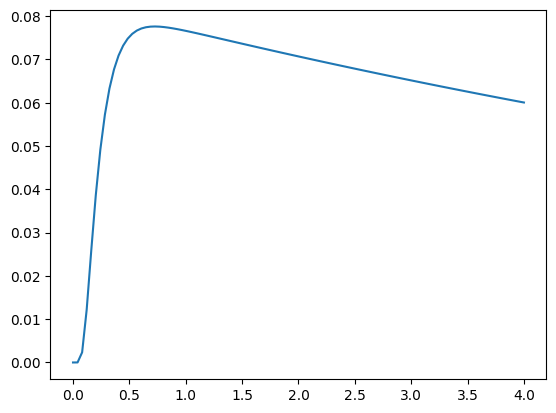

In [63]:
plt.plot(np.linspace(0, 4, 100), fpt(np.linspace(0, 4, 100)))

In [19]:
nu=0
fixed = 2**nu * gamma(1+nu)
fptt = lambda p: (threshold*sqrt(2*p))**nu/fixed *  1./besseli(nu, threshold*sqrt(2*p))

plt.plot(np.linspace(0.001, 4, 100),
         [invertlaplace(fptt, 1, method='talbot')for t in np.linspace(0.001, 4, 100)])

KeyboardInterrupt: 

In [6]:
for n in tqdm(range(150)):
    threshold = np.random.uniform(min_threshold, max_threshold)
    a = lambda t: threshold
    ndt = np.random.uniform(min_ndt, max_ndt)
    mu = np.array([np.random.uniform(min_mu, max_mu), 
                   np.random.uniform(min_mu, max_mu)])
    
    
    recovery_df['threshold_true'].append(threshold)
    recovery_df['ndt_true'].append(ndt)
    recovery_df['mu1_true'].append(mu[0])
    recovery_df['mu2_true'].append(mu[1])
    
    RT = []
    Theta = []
    
    for i in range(250):
        rt, theta = simulate_HSDM_2D(a, mu, ndt)
        RT.append(rt)
        Theta.append(theta)
    
    min_ans = minimize(HSDM_2D_likelihood,
                       args=(RT, Theta), 
                       x0=np.array([np.random.uniform(min_threshold, max_threshold),
                                    np.random.uniform(min_ndt, max_ndt), 
                                    np.random.uniform(min_mu, max_mu),
                                    np.random.uniform(min_mu, max_mu)]),
                       method='Nelder-Mead', 
                       bounds=[(min_threshold, max_threshold), (min_ndt, max_ndt),
                               (min_mu, max_mu), (min_mu, max_mu)])
    
    recovery_df['threshold_estimate'].append(min_ans.x[0])
    recovery_df['ndt_estimate'].append(min_ans.x[1])
    recovery_df['mu1_estimate'].append(min_ans.x[2])
    recovery_df['mu2_estimate'].append(min_ans.x[3])
    
recovery_df = pd.DataFrame(recovery_df)

100%|█████████████████████████████████████████████| 150/150 [13:16:53<00:00, 318.76s/it]


In [49]:
special.iv(1, 1000)

inf

In [52]:
special.ive(1, 3000)

0.007282745652054752